# Convolutional Autoencoder on MNIST dataset

**Learning Objective**
1. Build an autoencoder architecture (consisting of an encoder and decoder) in Keras
2. Define the loss using the reconstructive error
3. Define a training step for the autoencoder using tf.GradientTape()
4. Train the autoencoder on the MNIST dataset

## Introduction
This notebook demonstrates how to build and train a convolutional autoencoder.

Autoencoders consist of two models: an encoder and a decoder.

<img src="../assets/autoencoder2.png" width="600">

In this notebook we'll build an autoencoder to recreate MNIST digits. This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 100 epochs. The images increasingly resemble hand written digits as the autoencoder learns to reconstruct the original images.

<img src="../assets/autoencoder.gif">

In [1]:
from __future__ import absolute_import, division, print_function

import glob
import imageio
import os
import PIL
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from IPython import display

In [2]:
np.random.seed(1)
tf.random.set_seed(1)
BATCH_SIZE = 128
BUFFER_SIZE = 60000
EPOCHS = 60
LR = 1e-2
EMBED_DIM = 64 # intermediate_dim

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BATCH_SIZE*4)

In [6]:
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [7]:
def make_encoder(embed_dim):
    model = tf.keras.Sequential(name="encoder")
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(embed_dim))
    
    return model

In [8]:
def make_decoder(embed_dim):
    model = tf.keras.Sequential(name="decoder")
    model.add(layers.Dense(embed_dim, use_bias=False,
                           input_shape=(embed_dim,)))
    model.add(layers.Dense(6272, use_bias=False,
                           input_shape=(embed_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                                     use_bias=False, activation='tanh'))
    
    return model

In [9]:
ae_model = tf.keras.models.Sequential([make_encoder(EMBED_DIM), make_decoder(EMBED_DIM)])

In [10]:
ae_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 64)                608064    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         1047360   
Total params: 1,655,424
Trainable params: 1,642,496
Non-trainable params: 12,928
_________________________________________________________________


In [11]:
make_encoder(EMBED_DIM).summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0   

In [12]:
make_decoder(EMBED_DIM).summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                4096      
_________________________________________________________________
dense_5 (Dense)              (None, 6272)              401408    
_________________________________________________________________
batch_normalization_3 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512 

In [13]:
def loss(model, original):
    reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
    return reconstruction_error

In [14]:
#autoencoder.compile(loss="mse")
optimizer = tf.keras.optimizers.SGD(lr=LR)

In [15]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=ae_model)

In [16]:
def train_step(images):
    with tf.GradientTape() as tape:
        ae_gradients = tape.gradient(loss(ae_model, images),
                                     ae_model.trainable_variables)
    gradient_variables = zip(ae_gradients, ae_model.trainable_variables)
    
    optimizer.apply_gradients(gradient_variables)

In [17]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pixels = predictions[i, :, :] * 127.5 + 127.5
        pixels = np.array(pixels, dtype='float')
        pixels = pixels.reshape((28,28))
        plt.imshow(pixels, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [18]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(ae_model,
                                 epoch + 1,
                                 test_images[:16, :, :, :])

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(
            epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(ae_model,
                             epochs,
                             test_images[:16, :, :, :])

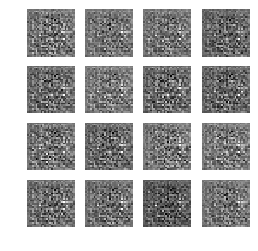

In [19]:
generate_and_save_images(ae_model, 4, test_images[:16, :, :, :])

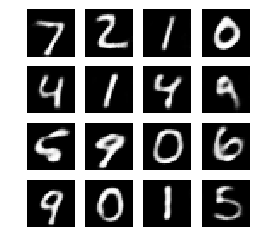

In [20]:
train(train_dataset, EPOCHS)

## Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('./ae_images/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'autoencoder.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./ae_images/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)